# Imports
***

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from pylab import rcParams

%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()
np.random.seed(8)

# Loading and visualizing data
***

In [17]:
header_list = ["spec_name", "impl_name", "set_size", "edge_prob", "policy_size", "spec_len", "rego_lines_of_code", "error_rate", "edge_number", "comp_cum_time", "result"]
df = pd.read_csv("one-id.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list)

chunks = pd.read_csv("equivalence.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list, chunksize=50000)
slim_data = []
for chunk in chunks:
    chunk["comp_cum_time"] *= 1000
    slim_data.append(chunk)
df = pd.concat(slim_data)

# Seconds to Milliseconds
#df["comp_cum_time"] *= 1000

df

,spec_name,impl_name,set_size,edge_prob,policy_size,spec_len,rego_lines_of_code,error_rate,edge_number,comp_cum_time,result
0,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.899,False
1,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.875,False
2,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,7.930,False
3,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,6.369,False
4,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.773,False
...,...,...,...,...,...,...,...,...,...,...,...
8995,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.767,False
8996,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.944,False
8997,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,6.717,False
8998,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.972,False


# Removing outliers and harmonizing sample size
***

In [18]:
# All values of predictors
set_sizes = sorted(df.set_size.unique())
policy_sizes = sorted(df.policy_size.unique())
error_rates = sorted(df.error_rate.unique())


# Removing 0.7 error rates values from data
#error_rates = error_rates[:-1]


print("Used values:")
print("Set sizes: {}".format(set_sizes))
print("Policy sizes: {}".format(policy_sizes))
print("Error rates: {}".format(error_rates))
print("")


# Making list of DFs by predictors
preds_df_list = []
labels = []
for set_size in set_sizes:
    for policy_size in policy_sizes:
        for error_rate in error_rates:
            print("DF parameters: {} {} {}".format(set_size, policy_size, error_rate))
            labels.append("{} {} {}".format(set_size, policy_size, error_rate))
            preds_df_list.append(df[(df.set_size == set_size) & (df.policy_size == policy_size) & (df.error_rate == error_rate)])
print("\n")


print("Unmodified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")


# Removing outliers in DFs
#new_preds_df_list = []
#for pred_df in preds_df_list: # Remove all values with Z-score > 3
#    new_preds_df_list.append( pred_df[np.abs(pred_df.comp_cum_time-pred_df.comp_cum_time.mean()) <= (3*pred_df.comp_cum_time.std())] )
#preds_df_list = new_preds_df_list


# Print DF shapes to check sample sizes, put them in list
preds_df_list_sample_sizes = []
print("No outliers DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
    preds_df_list_sample_sizes.append(pred_df.shape[0])
print("\n")

minimum_sample_size = min(preds_df_list_sample_sizes)
print("Minimum common sample size: {}".format(minimum_sample_size))

# Make sample sizes equal
new_preds_df_list = []
for pred_df in preds_df_list:
    new_preds_df_list.append(pred_df.head(minimum_sample_size))
preds_df_list = new_preds_df_list


# Check new DF shapes
print("Modified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")

Used values:
Set sizes: [100]
Policy sizes: [2]
Error rates: [0.4]

DF parameters: 100 2 0.4


Unmodified DF shapes
(9000, 11)


No outliers DF shapes
(9000, 11)


Minimum common sample size: 9000
Modified DF shapes
(9000, 11)




# Merge all data back together
***

In [19]:
merged_df = pd.DataFrame()
for pred_df in preds_df_list:
    merged_df = merged_df.append(pred_df)

df = merged_df

df

,spec_name,impl_name,set_size,edge_prob,policy_size,spec_len,rego_lines_of_code,error_rate,edge_number,comp_cum_time,result
0,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.899,False
1,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.875,False
2,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,7.930,False
3,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,6.369,False
4,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.773,False
...,...,...,...,...,...,...,...,...,...,...,...
8995,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.767,False
8996,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.944,False
8997,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,6.717,False
8998,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23843,0.4,649,5.972,False


In [23]:
spec_names = sorted(df.spec_name.unique())
print(spec_names)
impl_names = sorted(df.impl_name.unique())
print(impl_names)

['workflow-specs/randomly-generated/100-set-1-0-edges-2-policy/1.dat']
['impl-metagraph-generators/generated-from-random/100-set-1-0-edges-2-policy-0-4-error/1-1.py', 'impl-metagraph-generators/generated-from-random/100-set-1-0-edges-2-policy-0-4-error/1-10.py', 'impl-metagraph-generators/generated-from-random/100-set-1-0-edges-2-policy-0-4-error/1-11.py', 'impl-metagraph-generators/generated-from-random/100-set-1-0-edges-2-policy-0-4-error/1-12.py', 'impl-metagraph-generators/generated-from-random/100-set-1-0-edges-2-policy-0-4-error/1-13.py', 'impl-metagraph-generators/generated-from-random/100-set-1-0-edges-2-policy-0-4-error/1-14.py', 'impl-metagraph-generators/generated-from-random/100-set-1-0-edges-2-policy-0-4-error/1-15.py', 'impl-metagraph-generators/generated-from-random/100-set-1-0-edges-2-policy-0-4-error/1-16.py', 'impl-metagraph-generators/generated-from-random/100-set-1-0-edges-2-policy-0-4-error/1-17.py', 'impl-metagraph-generators/generated-from-random/100-set-1-0-edge

In [26]:
# Making list of DFs by spec_name
impl_name_df_list = []
for impl_name in impl_names:
    impl_name_df_list.append(df[(df.impl_name == impl_name)])
print("\n")
for df in impl_name_df_list:
    print(df)



                                             spec_name  \
0    workflow-specs/randomly-generated/100-set-1-0-...   
1    workflow-specs/randomly-generated/100-set-1-0-...   
2    workflow-specs/randomly-generated/100-set-1-0-...   
3    workflow-specs/randomly-generated/100-set-1-0-...   
4    workflow-specs/randomly-generated/100-set-1-0-...   
..                                                 ...   
295  workflow-specs/randomly-generated/100-set-1-0-...   
296  workflow-specs/randomly-generated/100-set-1-0-...   
297  workflow-specs/randomly-generated/100-set-1-0-...   
298  workflow-specs/randomly-generated/100-set-1-0-...   
299  workflow-specs/randomly-generated/100-set-1-0-...   

                                             impl_name  set_size  edge_prob  \
0    impl-metagraph-generators/generated-from-rando...       100        1.0   
1    impl-metagraph-generators/generated-from-rando...       100        1.0   
2    impl-metagraph-generators/generated-from-rando...       100

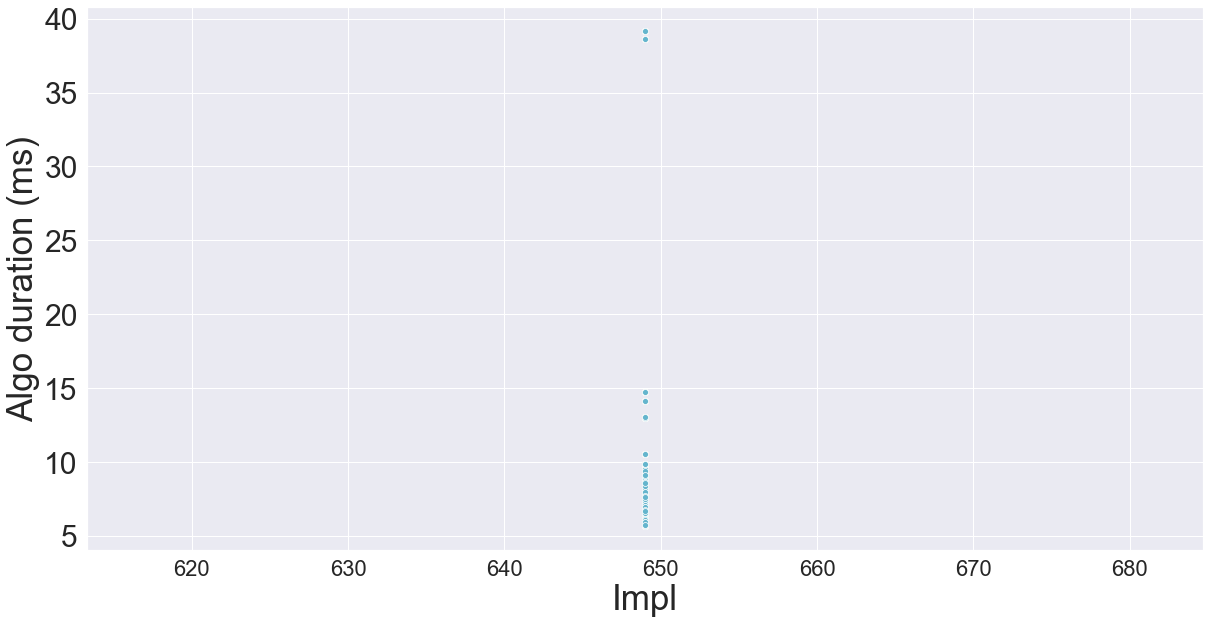

In [33]:
# Scatter plot
for impl_df in impl_name_df_list:
    sns.scatterplot(data=spec_df, x="edge_number", y="comp_cum_time")
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=30)
    plt.xlabel("Impl", fontsize=35)
    plt.ylabel("Algo duration (ms)", fontsize=35)

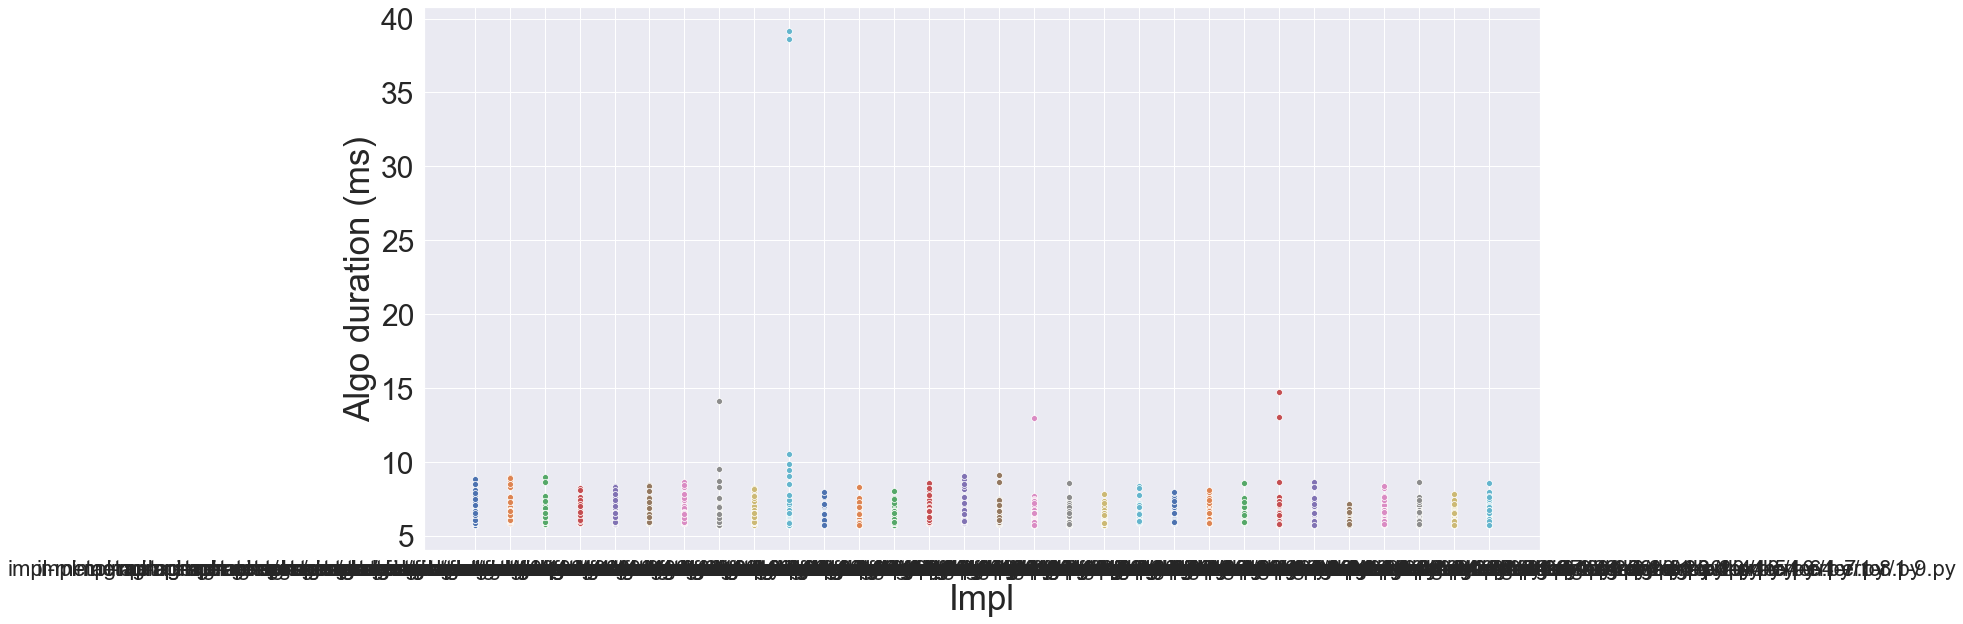

In [32]:
# Scatter plot
for impl_df in impl_name_df_list:
    sns.scatterplot(data=impl_df, x="impl_name", y="comp_cum_time")
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=30)
    plt.xlabel("Impl", fontsize=35)
    plt.ylabel("Algo duration (ms)", fontsize=35)

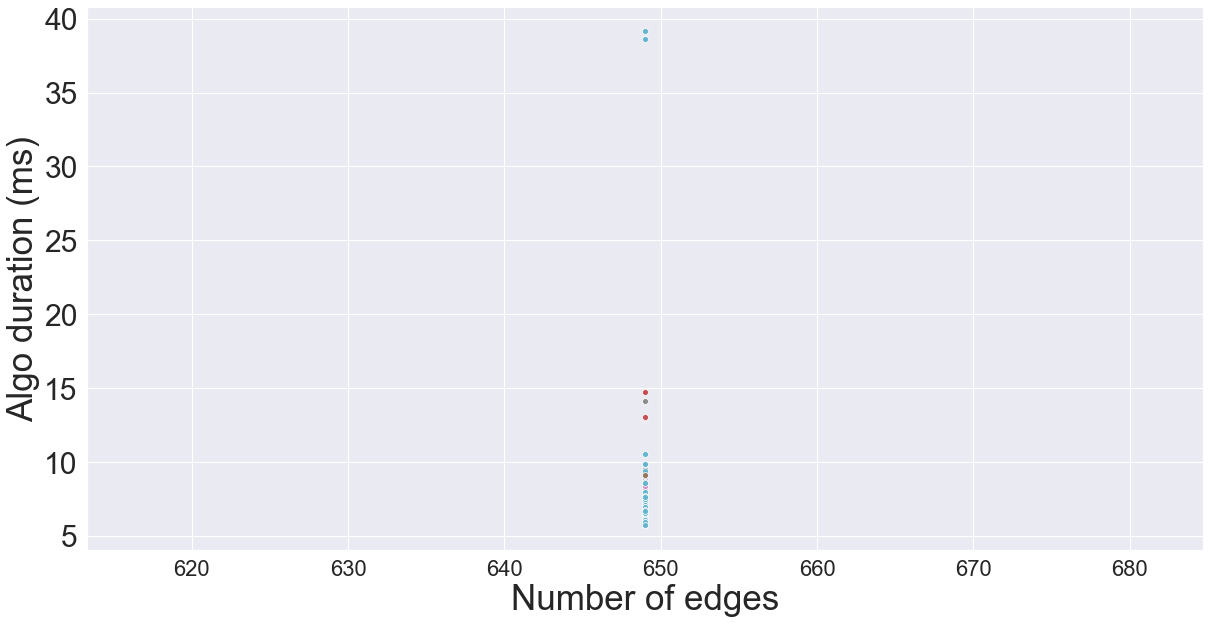

In [31]:
# Scatter plot
for impl_df in impl_name_df_list:
    sns.scatterplot(data=impl_df, x="edge_number", y="comp_cum_time")
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=30)
    plt.xlabel("Number of edges", fontsize=35)
    plt.ylabel("Algo duration (ms)", fontsize=35)